# BERT

Fine-tuned for classification with class weights to balance the dataset. Other options are SMOTE (Synthetic Minority Over-sampling Technique), but it may produce wrong results for medical data. Maybe undersampling could be tried next. Additionally, F1 may be a better evaluation metric compared to accuracy for an imbalanced dataset. https://community.ibm.com/community/user/ai-datascience/blogs/danish-hasarat/2024/03/28/dispelling-the-myth-is-f1-score-actually-better-th#:~:text=F1%2Dscore%20gives%20a%20more,may%20be%20preferred%20over%20accuracy.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

# Load your data into a pandas DataFrame
data = pd.read_csv('../data/balanced_classification_dataset.csv')  # replace 'your_dataset.csv' with your actual file

In [2]:
data = data.rename(columns={'data': 'text'})
data.head()

,Unnamed: 0.1,Unnamed: 0,patientid,sex,age,ANA,EXA,DIA_text,DIA_code,OP_text,OP_code,label,text
0,0,1,61.0,male,32.0,Beschwerden re. Achillessehne. NMR unauffällig...,Re. Achillessehne: Verdickung im Bereich der A...,Retropatellare Chondromalazie li; Insertionste...,M22.4,NaN,NaN,other,Beschwerden re. Achillessehne. NMR unauffällig...
1,1,2,67.0,male,41.0,Seit mehreren Monaten Beschwerden re. Achilles...,Re. Achillessehne: Deutliche Auftreibung der A...,V.a.laterale Chondromalazie bei st.n. Außenmen...,M23.3,NaN,NaN,meniskus_urgent,Seit mehreren Monaten Beschwerden re. Achilles...
2,2,6,72.0,male,19.0,. .Gestern beim Training stechende Schmerzen l...,Klinischer Befund des Oberschenkels li.deutl.V...,Z.n.arthroskopischer Chirurgie des Kniegelenkes.,M23.3,NaN,NaN,meniskus_urgent,. .Gestern beim Training stechende Schmerzen l...
3,3,7,72.0,male,23.0,beide Knie Schmerzen bei Treppe steigen oder L...,bd. Knie: frei Bewegl.; Patella o.B.; keine MZ...,Z.n.IM-Teilresektion re.,S83.2,NaN,NaN,meniskus_urgent,beide Knie Schmerzen bei Treppe steigen oder L...
4,4,9,84.0,male,57.0,(08.19 Uhr); bewegungsabhängig.Schmerzen wiede...,Klinischer Befund des Kniegelenks li.: Drucksc...,Beginnende Gonarthrose bds. li. mehr als re.,M17.9,NaN,NaN,other,(08.19 Uhr); bewegungsabhängig.Schmerzen wiede...


In [3]:
# Assuming you have two columns: 'text' and 'label'
texts = data['text'].values
labels = data['label'].values

# Encode the labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Split the data into train and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    texts, encoded_labels, test_size=0.2, random_state=42
)

In [4]:
# Undersampling, possibly remove
from imblearn.under_sampling import RandomUnderSampler
undersampler = RandomUnderSampler()
train_texts, train_labels = undersampler.fit_resample(train_texts.reshape(-1, 1), train_labels)
train_texts = train_texts.flatten()

In [23]:
print("Training set class distribution:", np.bincount(train_labels))
print("Test set class distribution:", np.bincount(test_labels))

Training set class distribution: [300 300 300 300 300 300]
Test set class distribution: [  85 1296  492 3618 3237  324]


In [5]:
from transformers import BertTokenizer

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('google-bert/bert-base-german-cased')

# Tokenize the data
train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding='max_length', max_length=400)
test_encodings = tokenizer(test_texts.tolist(), truncation=True, padding='max_length', max_length=400)

In [6]:
import tensorflow as tf

def create_dataset(encodings, labels):
    dataset = tf.data.Dataset.from_tensor_slices((
        dict(encodings),
        labels
    ))
    return dataset

train_dataset = create_dataset(train_encodings, train_labels)
test_dataset = create_dataset(test_encodings, test_labels)

2024-07-19 22:46:13.064464: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2024-07-19 22:46:13.064485: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2024-07-19 22:46:13.064488: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2024-07-19 22:46:13.064502: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-19 22:46:13.064514: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
from transformers import TFBertForSequenceClassification

# Load the BERT model for sequence classification with the number of output labels
model = TFBertForSequenceClassification.from_pretrained('google-bert/bert-base-german-cased', num_labels=len(label_encoder.classes_))

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
# import numpy as np
# class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
# class_weights_dict = dict(enumerate(class_weights))

In [21]:
# class_weights

array([1., 1., 1., 1., 1., 1.])

In [9]:
import tensorflow.keras as keras
# Compile the model
model.compile(
    #optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.F1Score()]
)

In [10]:
# Train the model
model.fit(train_dataset.shuffle(1000).batch(32),
          epochs=3,
          batch_size=32,
        #   class_weight=class_weights_dict
          )


Epoch 1/3


2024-07-19 22:46:20.844626: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


57/57 [==============================] - 65s 745ms/step - loss: 1.9774 - f1_score: 0.2993
Epoch 2/3
57/57 [==============================] - 42s 742ms/step - loss: 1.8322 - f1_score: 0.3107
Epoch 3/3
57/57 [==============================] - 51s 890ms/step - loss: 1.8298 - f1_score: 0.3106


In [11]:
model.save_pretrained('german_bert_classify_model_weights')  # replace with your desired path
tokenizer.save_pretrained('german_bert_classify_tokenizer_weights')  # replace with your desired path

('german_bert_classify_tokenizer_weights/tokenizer_config.json',
 'german_bert_classify_tokenizer_weights/special_tokens_map.json',
 'german_bert_classify_tokenizer_weights/vocab.txt',
 'german_bert_classify_tokenizer_weights/added_tokens.json')

In [12]:
# Evaluate the model
loss, accuracy = model.evaluate(test_dataset.batch(32))
print(f'Loss: {loss}')
print(f'F1: {accuracy}')

283/283 [==============================] - 193s 665ms/step - loss: 2.9028 - f1_score: 0.2984
Loss: 2.902796983718872
Accuracy: 0.29843512177467346


In [13]:
import numpy as np
predictions = model.predict(test_dataset.batch(32))
predicted_labels = np.argmax(predictions.logits, axis=-1)

# Decode class labels to original labels
decoded_predictions = label_encoder.inverse_transform(predicted_labels)

# True labels from the test set
true_labels = label_encoder.inverse_transform(test_labels)

# Create a DataFrame to compare
comparison_df = pd.DataFrame({'Text': test_texts, 'True Label': true_labels, 'Predicted Label': decoded_predictions})

283/283 [==============================] - 110s 377ms/step


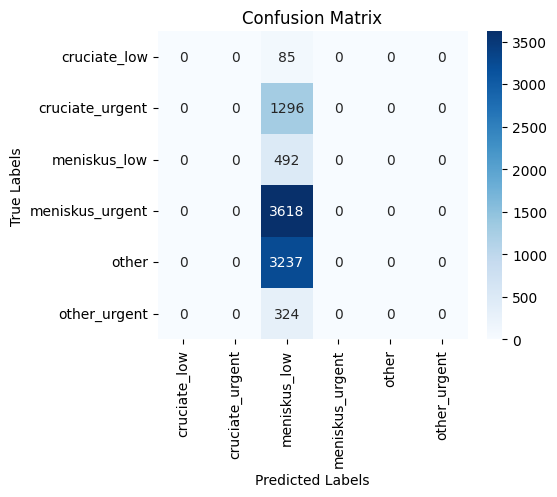

In [14]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(true_labels, decoded_predictions, labels=label_encoder.classes_)

# Plot the confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [15]:
from sklearn.metrics import classification_report
print(classification_report(true_labels, decoded_predictions, target_names=label_encoder.classes_))

                 precision    recall  f1-score   support

   cruciate_low       0.00      0.00      0.00        85
cruciate_urgent       0.00      0.00      0.00      1296
   meniskus_low       0.05      1.00      0.10       492
meniskus_urgent       0.00      0.00      0.00      3618
          other       0.00      0.00      0.00      3237
   other_urgent       0.00      0.00      0.00       324

       accuracy                           0.05      9052
      macro avg       0.01      0.17      0.02      9052
   weighted avg       0.00      0.05      0.01      9052



/opt/homebrew/Caskroom/miniconda/base/envs/tf2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/tf2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/tf2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av